# Exercise 1

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

---

In [1]:
# Pydata stack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

import time

from sklearn import set_config  # Displays HTML representation of composite estimators
from sklearn.datasets import fetch_openml  # For open source ML sets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

set_config(display="diagram")

import os

import joblib

In [2]:
# useful decorator
def computation_time(func):
    def inner(*args, **kwargs):
        start = time.perf_counter()
        func(*args, **kwargs)
        end = time.perf_counter()
        print("Computation time: {:.1f} seconds".format(end - start))

    return inner

In [3]:
MODELS_FOLDER = "models"
MNIST_KNEIGHBOURS_CLASSIFIER_PATH = os.path.join(
    MODELS_FOLDER, "mnist-k-neighbours-classifier.pkl"
)

## Get The Data

In [4]:
mnist = fetch_openml("mnist_784", version=1)

# load data into dataframes
X, y = mnist["data"], mnist["target"]

# use predefined train/test split
X_train, X_test, y_train, y_test = (
    X.iloc[:60000],
    X.iloc[60000:],
    y.iloc[:60000],
    y.iloc[60000:],
)
num_samples = X_train.shape[0]

Is the dataset skewed?

In [5]:
class_counts = y_train.value_counts().sort_index()
class_pcts = 100 * class_counts / num_samples
class_pcts.round(1)

0     9.9
1    11.2
2     9.9
3    10.2
4     9.7
5     9.0
6     9.9
7    10.4
8     9.8
9     9.9
Name: class, dtype: float64

Different classes are essentially balanced.

## Select and Train Model

Use K-Nearest Neighbors classifier.

**Warning:** This cell takes around 35 minutes to run! To save time we pickle the best model and load it if it exists.

In [6]:
@computation_time
def knc_grid_search(X, y):
    # initialise
    knc_clf = KNeighborsClassifier()

    # hyperparams to try
    param_grid = [{"n_neighbors": [3, 4, 5], "weights": ["uniform", "distance"]}]

    grid_search = GridSearchCV(
        knc_clf,
        param_grid,
        scoring="accuracy",
        cv=5,
        return_train_score=True,
        refit=True,
    )

    grid_search.fit(X, y)

    cv_results = grid_search.cv_results_

    cv_summary = pd.DataFrame(cv_results["params"])
    cv_summary["mean_train_score"] = cv_results["mean_train_score"].round(3)
    cv_summary["mean_test_score"] = cv_results["mean_test_score"].round(3)
    cv_summary = cv_summary.sort_values(by="mean_test_score", ascending=False)

    return grid_search.best_estimator_, cv_results, cv_summary


if os.path.isfile(MNIST_KNEIGHBOURS_CLASSIFIER_PATH):
    knc_clf = joblib.load(MNIST_KNEIGHBOURS_CLASSIFIER_PATH)
else:
    knc_clf, cv_results, cv_summary = knc_grid_search(X_train, y_train)
    print(cv_summary)

    joblib.dump(knc_clf, MNIST_KNEIGHBOURS_CLASSIFIER_PATH)

knc_clf

KNeighborsClassifier(n_neighbors=4, weights='distance')

Training error isn't actually a useful metric here. We are weighting the importance of points by their distance. If a point in the training set is evaluated, it will be weighted very highly and so the algorithm will always give that label as its prediction. I think it's better to just look at test error.

## Evaluate on Test Set

In [7]:
y_test_pred = knc_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)

print("Test Accuracy: {:.1f}%".format(100 * acc))

Test Accuracy: 97.1%


# Exercise 2

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per directionn) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called *data augmentation* or *training set expansion*.

---

In [98]:
from random import randint
from scipy.ndimage.interpolation import shift

# want underlying arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

n_samples = len(y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

First show a random digit

Digit label: 2


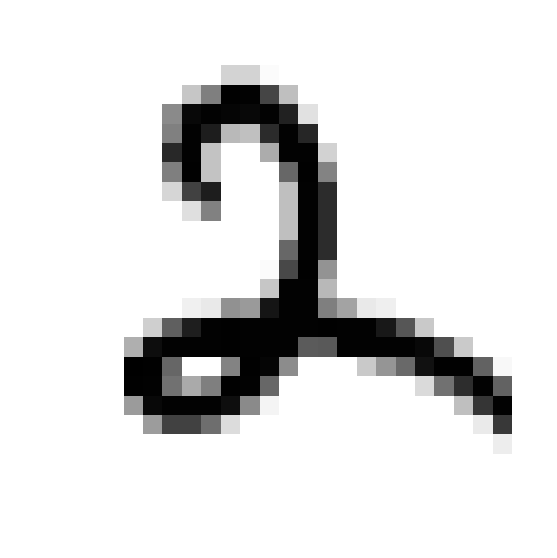

In [99]:
def show_digit(digit, ax=None):
    digit_image = digit.reshape(28, 28)
    
    if ax:
        ax.imshow(digit_image, cmap="binary")
        ax.axis("off")
    else:
        plt.imshow(digit_image, cmap="binary")
        ax=plt.gca()
    
    ax.axis("off")
    
# print random digit
ex_ix = randint(0, num_samples - 1)
print("Digit label: {}".format(y_train[ex_ix]))

ex_digit = X_train[ex_ix, :]
show_digit(ex_digit)

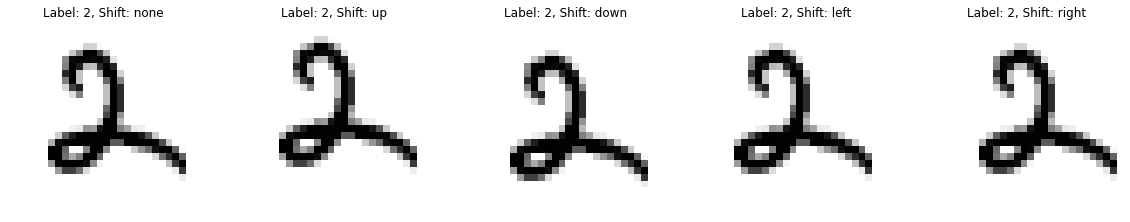

In [101]:
def shift_digits_one_pixel(X, direction):
    direction_dict = {
        "up":[0, -1, 0],
        "down":[0, 1, 0],
        "left":[0, 0, -1],
        "right": [0, 0, 1]
    }
    direction_shift = direction_dict[direction]
    
    # reshape so each row is a 28x28 array
    n_samples = len(X)
    X_images = X.reshape(n_samples, 28, 28)
    X_images_shift = shift(X_images, direction_shift)
    X_shift = X_images_shift.reshape(n_samples, 784)
    
    return X_shift


def augment_data(X, y):
    X_aug = X.copy()
    y_aug = y.copy()
    
    for direction in ["up", "down", "left", "right"]:
        X_shift = shift_digits_one_pixel(X, direction)
        X_aug = np.r_[X_aug, X_shift]
        
        y_aug = np.r_[y_aug, y]
    
    return X_aug, y_aug


def plot_shifted_digits(X_aug, y_aug, ix):
    fig, axs = plt.subplots(1, 5)

    for i, direction in enumerate(["none", "up", "down", "left", "right"]):
        ax = axs[i]

        ix_shift = ix + n_samples * i
        
        digit = X_aug[ix_shift, :]
        label = y_aug[ix_shift]
        
        show_digit(digit, ax=ax)
        
        ax.set_title("Label: {}, Shift: {}".format(label, direction))


X_train_aug, y_train_aug = augment_data(X_train, y_train)
plot_shifted_digits(X_train_aug, y_train_aug, ex_ix)

Train KNeighbours classifier on augmented data and test

In [103]:
@computation_time
def fit_classifier(clf, X, y):
    clf.fit(X, y)
    
    return clf


fit_classifier(knc_clf, X_train_aug, y_train_aug)

Computation time: 0.8 seconds


In [105]:
knc_clf.fit(X_train_aug, y_train_aug)
y_test_pred = knc_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)

print("Test Accuracy: {:.1f}%".format(100 * acc))

Test Accuracy: 97.6%


This is actually only slightly better.